### Introduction and Methodology: ###

National happiness scores are constructed by the United Nations using multiple structural and social factors, such as GDP per capita, social support, and perceived freedom, which are often tightly inter‑related (https://www.worldhappiness.report/faq/). 

Correlation analysis can reveal clusters of factors that tend to move together, indicating potential redundancy or shared underlying dimensions (https://www.geeksforgeeks.org/data-analysis/what-is-correlation-analysis/). Importantly, strong correlations between happiness determinants do not imply that these variables are interchangeable or redundant. Rather, they indicate that multiple factors may reflect overlapping structural conditions shaping wellbeing, such as economic security or social stability. 

Throughout this analysis, correlations are therefore interpreted as evidence of shared variance and structural linkage, rather than direct causal dominance of one factor over another.
In this project, we have used global happiness data from the 2015–2019 UN world happiness reports (https://www.kaggle.com/datasets/unsdsn/world-happiness/data), and combined this with global unemployment rates from the same time period, sourced from the UN's International Labor Organization (https://www.kaggle.com/datasets/sazidthe1/global-unemployment-data). 

Our project examines the following three question:

1.      Which original happiness predictors are most strongly inter‑correlated?
2.      Whether or not unemployment provides additional explanatory power for happiness beyond these overlapping relationships 
3.      Can unemployment data can replace bespoke data collected specifically for the happiness report?

We have chosen unemployment as a factor due to the fact that it is already a collected metric, meaning if it were able to be accurately incorporated into the calculations of happiness scores it would save data collection resources. Furthermore, following relevant reading, we have come to understand that on a social dimension, employment is a huge contributing factor to people’s well-being and happiness (https://www.tandfonline.com/doi/full/10.1080/1359432X.2022.2106855#abstract).

Using a combination of correlations, and (linear and multiple) regressions, our analysis evaluates which factors are the most significant determinants of happiness, and whether unemployment captures something substantively new about wellbeing or largely reflects existing economic and social factors.

This notebook is organised into multiple parts, as explained by individual markdowns. The parts are as follows:
1.      Set-up, cleaning, pre-processing and merging
2.      Inter-factor and unemployment correlation plots
3.      Linear regressions on significant inter-factor relationships and unemployment
4.      Multiple regressions with various significant factors including unemployment
5.      Shiny app to visualise the relationships between the factors
6.      Findings, limitations, scope for further study, and conclusion


### 1. Set-up, cleaning, pre-processing and merging:
This section involved importing all relevant libraries and loading in the data.

We then worked with the happiness datasets, renaming and dropping columns in each individual happiness score dataset from 2015 - 2019 before merging them together. We also had to rename or drop countries that did not appear or were called different things in each year's dataset respectively.

Afterwards, we tackled the unemployment dataset in the same way, alongside combining all of the years into one column and removing unnecessary columns.

Finally, we combined the two clean datasets into one dataframe to work with. To ensure consistency across sources, unemployment rates were aggregated to a country–year level, aligning them with the structure of the happiness dataset. 

This involved a trade-off between retaining granular demographic detail and achieving a harmonised dataset suitable for cross-national comparison, prioritising analytical consistency over maximal coverage.


In [1]:
# import necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
git_url = 'https://github.com/knnthfrmn/dsc25_group.git'

In [2]:
# load all data

unemployment_data = pd.read_csv('data/global_unemployment_data.csv')
happiness_2015 = pd.read_csv('data/happiness data/2015.csv')
happiness_2016 = pd.read_csv('data/happiness data/2016.csv')
happiness_2017 = pd.read_csv('data/happiness data/2017.csv')
happiness_2018 = pd.read_csv('data/happiness data/2018.csv')
happiness_2019 = pd.read_csv('data/happiness data/2019.csv')

# add year column to happiness dataframes

happiness_2015['Year'] = 2015
happiness_2016['Year'] = 2016
happiness_2017['Year'] = 2017
happiness_2018['Year'] = 2018
happiness_2019['Year'] = 2019


In [3]:
happiness_2015 = happiness_2015.rename(columns={'Economy (GDP per Capita)': 'GDP per cap', 
                                                'Health (Life Expectancy)': 'Life Expectancy', 
                                                'Trust (Government Corruption)': 'Corruption'})

In [4]:
happiness_2015 = happiness_2015.drop(columns={'Region', 'Standard Error', 'Dystopia Residual'})

In [5]:
happiness_2016 = happiness_2016.rename(columns={'Economy (GDP per Capita)': 'GDP per cap', 
                                                'Health (Life Expectancy)': 'Life Expectancy', 
                                                'Trust (Government Corruption)': 'Corruption'})

In [6]:
happiness_2016 = happiness_2016.drop(columns={'Region', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Dystopia Residual'})

In [7]:
happiness_2017 = happiness_2017.rename(columns={'Happiness.Rank': 'Happiness Rank', 
                                                'Happiness.Score': 'Happiness Score', 
                                                'Economy..GDP.per.Capita.': 'GDP per cap',
                                                'Health..Life.Expectancy.': 'Life Expectancy',
                                                'Trust..Government.Corruption.': 'Corruption'})

In [8]:
happiness_2017 = happiness_2017.drop(columns={'Whisker.high', 'Whisker.low', 'Dystopia.Residual'})

In [9]:
happiness_2018 = happiness_2018.rename(columns={'GDP per capita': 'GDP per cap',
                                                'Country or region': 'Country',
                                                'Score': 'Happiness Score',
                                                'Overall rank': 'Happiness Rank',
                                                'Social support': 'Family',
                                                'Healthy life expectancy': 'Life Expectancy',
                                                'Perceptions of corruption': 'Corruption',
                                                'Freedom to make life choices': 'Freedom'})

In [10]:
happiness_2019 = happiness_2019.rename(columns={'GDP per capita': 'GDP per cap',
                                                'Country or region': 'Country',
                                                'Score': 'Happiness Score',
                                                'Overall rank': 'Happiness Rank',
                                                'Social support': 'Family',
                                                'Healthy life expectancy': 'Life Expectancy',
                                                'Perceptions of corruption': 'Corruption',
                                                'Freedom to make life choices': 'Freedom'})

In [11]:
# merge all happiness data by year into one big dataframe
happiness_data = pd.concat([happiness_2015, happiness_2016, happiness_2017, happiness_2018, happiness_2019])

In [12]:
happiness_data = happiness_data.reset_index()
happiness_data.head()

,index,Country,Happiness Rank,Happiness Score,GDP per cap,Family,Life Expectancy,Freedom,Corruption,Generosity,Year
0,0,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2015
1,1,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2015
2,2,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2015
3,3,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2015
4,4,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2015


In [13]:
happiness_data = happiness_data.drop(columns={'index'})
happiness_data

,Country,Happiness Rank,Happiness Score,GDP per cap,Family,Life Expectancy,Freedom,Corruption,Generosity,Year
0,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2015
1,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2015
2,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2015
3,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2015
4,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2015
...,...,...,...,...,...,...,...,...,...,...
777,Rwanda,152,3.334,0.35900,0.71100,0.61400,0.55500,0.41100,0.21700,2019
778,Tanzania,153,3.231,0.47600,0.88500,0.49900,0.41700,0.14700,0.27600,2019
779,Afghanistan,154,3.203,0.35000,0.51700,0.36100,0.00000,0.02500,0.15800,2019
780,Central African Republic,155,3.083,0.02600,0.00000,0.10500,0.22500,0.03500,0.23500,2019


In [14]:
happiness_data['Country'].describe()

count             782
unique            170
top       Switzerland
freq                5
Name: Country, dtype: object

In [15]:
# count how many countries don't appear in all 5 separate dataframes
pd.Series.value_counts(happiness_data['Country'].value_counts() != 5)

count
False    141
True      29
Name: count, dtype: int64

In [16]:
# look at which countries don't appear in all 5 separate dataframes
(happiness_data['Country'].value_counts() != 5).tail(29)

Country
Taiwan                      True
Namibia                     True
Central African Republic    True
Somalia                     True
Laos                        True
South Sudan                 True
Angola                      True
Hong Kong                   True
Lesotho                     True
Macedonia                   True
Mozambique                  True
Sudan                       True
Trinidad and Tobago         True
Belize                      True
Comoros                     True
North Cyprus                True
Suriname                    True
Trinidad & Tobago           True
Swaziland                   True
Northern Cyprus             True
Oman                        True
Somaliland region           True
Djibouti                    True
Somaliland Region           True
Puerto Rico                 True
Hong Kong S.A.R., China     True
Taiwan Province of China    True
North Macedonia             True
Gambia                      True
Name: count, dtype: bool

In [17]:
# Taiwan, Hong Kong, and Somaliland Region have duplicate namings, so can be combined
drop = ['2014','2020','2021','2022','2023','2024']
unemployment_data = unemployment_data.drop(columns = drop)
#unemployment_data = unemployment_data[(unemployment_data['year'] >= start_year) & (df['year'] <= end_year)]
#standardizing names
unemployment_data['Country'] = unemployment_data['country_name']
happiness_data['Country'] = happiness_data['Country'].replace({'Congo (Kinshasa)':'Congo, Democratic Republic of the'})
happiness_data['Country'] = happiness_data['Country'].replace({'Congo (Brazzaville)':'Congo'})
happiness_data['Country'] = happiness_data['Country'].replace({'Iran':'Iran, Islamic Republic of'})
unemployment_data['Country'] = unemployment_data['Country'].replace({'Viet Nam':'Vietnam'})
unemployment_data['Country'] = unemployment_data['Country'].replace({'Czechia':'Czech Republic'})
happiness_data['Country'] = happiness_data['Country'].replace({'Hong Kong S.A.R., China':'Hong Kong'})
happiness_data['Country'] = happiness_data['Country'].replace({'Taiwan Provice of China':'Taiwan'})
unemployment_data['Country'] = unemployment_data['Country'].replace({'Taiwan, China':'Taiwan'})

happiness_data['Country'].unique()

array(['Switzerland', 'Iceland', 'Denmark', 'Norway', 'Canada', 'Finland',
       'Netherlands', 'Sweden', 'New Zealand', 'Australia', 'Israel',
       'Costa Rica', 'Austria', 'Mexico', 'United States', 'Brazil',
       'Luxembourg', 'Ireland', 'Belgium', 'United Arab Emirates',
       'United Kingdom', 'Oman', 'Venezuela', 'Singapore', 'Panama',
       'Germany', 'Chile', 'Qatar', 'France', 'Argentina',
       'Czech Republic', 'Uruguay', 'Colombia', 'Thailand',
       'Saudi Arabia', 'Spain', 'Malta', 'Taiwan', 'Kuwait', 'Suriname',
       'Trinidad and Tobago', 'El Salvador', 'Guatemala', 'Uzbekistan',
       'Slovakia', 'Japan', 'South Korea', 'Ecuador', 'Bahrain', 'Italy',
       'Bolivia', 'Moldova', 'Paraguay', 'Kazakhstan', 'Slovenia',
       'Lithuania', 'Nicaragua', 'Peru', 'Belarus', 'Poland', 'Malaysia',
       'Croatia', 'Libya', 'Russia', 'Jamaica', 'North Cyprus', 'Cyprus',
       'Algeria', 'Kosovo', 'Turkmenistan', 'Mauritius', 'Hong Kong',
       'Estonia', 'Indonesi

In [18]:
unemployment_data['Country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Channel Islands',
       'Chile', 'China', 'Colombia', 'Comoros', 'Congo',
       'Congo, Democratic Republic of the', 'Costa Rica', 'Croatia',
       'Cuba', 'Cyprus', 'Czech Republic', 'Ivory Coast', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'French Polynesia', 'Gabon', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Greece', 'Guam', 'Guatemala', 'Guinea', 'Guinea-Bissau'

In [19]:
unemployment_data.head()

,country_name,indicator_name,sex,age_group,age_categories,2015,2016,2017,2018,2019,Country
0,Afghanistan,Unemployment rate by sex and age,Female,15-24,Youth,15.974,18.570,21.137,20.649,20.154,Afghanistan
1,Afghanistan,Unemployment rate by sex and age,Female,25+,Adults,9.014,9.463,9.920,11.223,12.587,Afghanistan
2,Afghanistan,Unemployment rate by sex and age,Female,Under 15,Children,11.552,12.789,14.017,14.706,15.418,Afghanistan
3,Afghanistan,Unemployment rate by sex and age,Male,15-24,Youth,11.502,13.772,16.027,15.199,14.361,Afghanistan
4,Afghanistan,Unemployment rate by sex and age,Male,25+,Adults,6.879,7.301,7.728,7.833,7.961,Afghanistan


In [20]:
year_cols = ['2015', '2016', '2017', '2018', '2019']

long_unemp = unemployment_data.melt(
    id_vars=['country_name', 'sex', 'age_group', 'age_categories', 'Country'],
    value_vars=year_cols,
    var_name='year',
    value_name='unemployment_rate'
)
long_unemp['year'] = long_unemp['year'].astype(int)

In [21]:
long_unemp.drop(columns=['country_name', 'sex', 'age_categories'])
#remove superfluous data

,age_group,Country,year,unemployment_rate
0,15-24,Afghanistan,2015,15.974
1,25+,Afghanistan,2015,9.014
2,Under 15,Afghanistan,2015,11.552
3,15-24,Afghanistan,2015,11.502
4,25+,Afghanistan,2015,6.879
...,...,...,...,...
5665,25+,Zimbabwe,2019,5.309
5666,Under 15,Zimbabwe,2019,6.990
5667,15-24,Zimbabwe,2019,11.048
5668,25+,Zimbabwe,2019,6.362


In [22]:
avg_country_year = (long_unemp.groupby(['Country', 'year'])['unemployment_rate'].mean().reset_index())
#creating single unemployment rate per country+year

In [23]:
avg_country_year = avg_country_year.rename(columns={'year': 'Year', 'unemployment_rate' : 'Unemployment'})
#standardized column names

In [24]:
avg_country_year

,Country,Year,Unemployment
0,Afghanistan,2015,10.546000
1,Afghanistan,2016,11.876167
2,Afghanistan,2017,13.198167
3,Afghanistan,2018,13.291167
4,Afghanistan,2019,13.401833
...,...,...,...
940,Zimbabwe,2015,5.982500
941,Zimbabwe,2016,6.573167
942,Zimbabwe,2017,7.088667
943,Zimbabwe,2018,7.594667


In [25]:
avg_country_year['Country Year'] = avg_country_year['Country'].astype(str) + '_' + avg_country_year['Year'].astype(str)
happiness_data['Country Year'] = happiness_data['Country'].astype(str) + '_' + happiness_data['Year'].astype(str)
#merge data frames on new, common column
combined_df = pd.merge(happiness_data, avg_country_year, on=['Country Year'])

In [26]:
#remove superfluous columns
drop_2 = ['Country_x','Year_x']
combined_df = combined_df.drop(columns = drop_2)
#combined_df

In [27]:
#checking for nan to ensure smooth merge
combined_df['Freedom'].isna().any()

np.False_

In [28]:
combined_df['Unemployment'].isna().any()

np.False_

In [29]:
combined_df = combined_df.rename(columns={'Country_y':'Country','Year_y':'Year'})
combined_df

,Happiness Rank,Happiness Score,GDP per cap,Family,Life Expectancy,Freedom,Corruption,Generosity,Country Year,Country,Year,Unemployment
0,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,Switzerland_2015,Switzerland,2015,5.942000
1,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,Iceland_2015,Iceland,2015,5.178333
2,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,Denmark_2015,Denmark,2015,7.906000
3,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,Norway_2015,Norway,2015,5.854667
4,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,Canada_2015,Canada,2015,8.526167
...,...,...,...,...,...,...,...,...,...,...,...,...
717,151,3.380,0.28700,1.16300,0.46300,0.14300,0.07700,0.10800,Yemen_2019,Yemen,2019,25.470000
718,152,3.334,0.35900,0.71100,0.61400,0.55500,0.41100,0.21700,Rwanda_2019,Rwanda,2019,12.383500
719,154,3.203,0.35000,0.51700,0.36100,0.00000,0.02500,0.15800,Afghanistan_2019,Afghanistan,2019,13.401833
720,155,3.083,0.02600,0.00000,0.10500,0.22500,0.03500,0.23500,Central African Republic_2019,Central African Republic,2019,6.985000


### 2. Inter-factor and unemployment correlation plots:

This section involved plotting the relationships between:

a)      The happiness score and the factors used to determine it

b)      The factors with one another

c)      The happiness score and the unemployment score

d)      The unemployment score and the happiness score factors

These visualisations are used to assess the strength, direction, and degree of overlap between key happiness determinants. In particular, they allow us to identify clusters of strongly related variables, highlighting potential structural groupings within the happiness model and informing later regression analyses by revealing where multicollinearity or shared explanatory pathways may be present.

We found the p values, the r values, and the r squared values for each relationship, and in doing so were able to establish which factors of the happiness score are most significant, alongside whether or not unemployment could be an additional or substituted factor.

See our shiny app (app.py) to segregate and observe correlations between individual factors

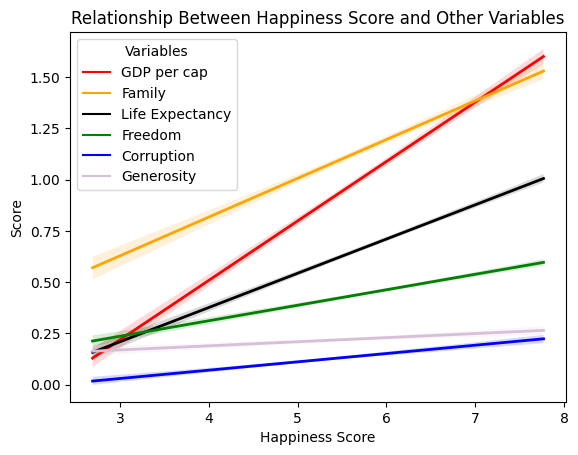

Model Evaluation:
Happiness Score x GDP per cap:  r = 0.802,   p = 0.000,   R-squared = 0.643
Happiness Score x Family:  r = 0.652,   p = 0.000,   R-squared = 0.424
Happiness Score x Life Expectancy:  r = 0.764,   p = 0.000,   R-squared = 0.583
Happiness Score x Freedom:  r = 0.566,   p = 0.000,   R-squared = 0.321
Happiness Score x Corruption:  r = 0.436,   p = 0.000,   R-squared = 0.190
Happiness Score x Generosity:  r = 0.187,   p = 0.000,   R-squared = 0.035


In [30]:
# Visualise all linear relationships between happiness score and contributors

x_var = 'Happiness Score'
y_vars = ['GDP per cap', 'Family', 'Life Expectancy', 'Freedom', 'Corruption', 'Generosity']
colors = ['red', 'orange', 'black', 'green', 'blue', 'thistle']

handles = []
for y, c in zip(y_vars, colors):

    sns.regplot(
        data=combined_df,
        x=x_var, y=y,
        scatter=False,
        line_kws={'color': c, 'linewidth': 2},
    )

    handles.append(plt.Line2D([], [], color=c))

plt.xlabel(x_var)
plt.ylabel("Score")
plt.title(f"Relationship Between {x_var} and Other Variables")

plt.legend(handles, y_vars, title="Variables")

plt.show()

# Also show how 'good' of a model each line is using r-squared and pearson

print('Model Evaluation:')
for y in y_vars:
    df_clean = combined_df[[x_var, y]].dropna()

    X = df_clean[[x_var]].values
    Y = df_clean[y].values

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, Y)

    # R-squared
    r2 = model.score(X, Y)

    # Pearson correlation
    r, p = pearsonr(df_clean[x_var], df_clean[y])

    print(f"{x_var} x {y}:  r = {r:.3f},   p = {p:.3f},   R-squared = {r2:.3f}")

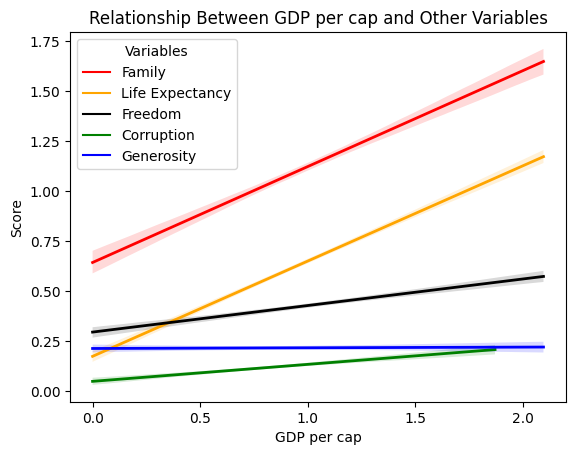

Model Evaluation:
GDP per cap x Family:  r = 0.597,   p = 0.000,   R-squared = 0.357
GDP per cap x Life Expectancy:  r = 0.787,   p = 0.000,   R-squared = 0.619
GDP per cap x Freedom:  r = 0.360,   p = 0.000,   R-squared = 0.129
GDP per cap x Corruption:  r = 0.328,   p = 0.000,   R-squared = 0.108
GDP per cap x Generosity:  r = 0.012,   p = 0.757,   R-squared = 0.000


In [31]:
# Visualise all linear relationships between happiness score contributors
# Visualised as how 'x' variable is related with all other variables

x_var = 'GDP per cap'
y_vars = ['Family', 'Life Expectancy', 'Freedom', 'Corruption', 'Generosity']
colors = ['red', 'orange', 'black', 'green', 'blue']

handles = []
for y, c in zip(y_vars, colors):

    sns.regplot(
        data=combined_df,
        x=x_var, y=y,
        scatter=False,
        line_kws={'color': c, 'linewidth': 2},
    )

    handles.append(plt.Line2D([], [], color=c))

plt.xlabel(x_var)
plt.ylabel("Score")
plt.title(f"Relationship Between {x_var} and Other Variables")

plt.legend(handles, y_vars, title="Variables")

plt.show()

# Also show how 'good' of a model each line is using r-squared and pearson

print('Model Evaluation:')
for y in y_vars:
    df_clean = combined_df[[x_var, y]].dropna()

    X = df_clean[[x_var]].values
    Y = df_clean[y].values

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, Y)

    # R-squared
    r2 = model.score(X, Y)

    # Pearson correlation
    r, p = pearsonr(df_clean[x_var], df_clean[y])

    print(f"{x_var} x {y}:  r = {r:.3f},   p = {p:.3f},   R-squared = {r2:.3f}")

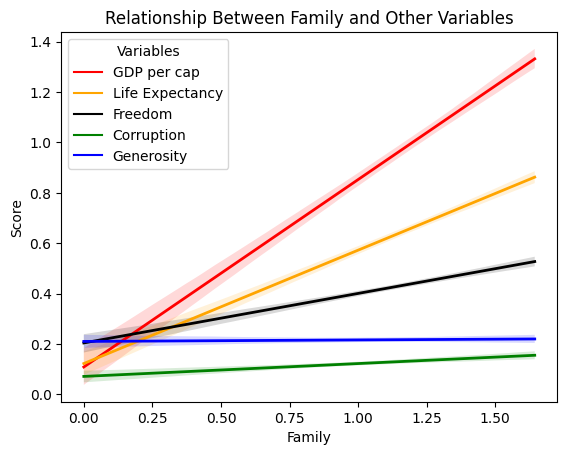

Model Evaluation:
Family x GDP per cap:  r = 0.597,   p = 0.000,   R-squared = 0.357
Family x Life Expectancy:  r = 0.597,   p = 0.000,   R-squared = 0.356
Family x Freedom:  r = 0.427,   p = 0.000,   R-squared = 0.182
Family x Corruption:  r = 0.159,   p = 0.000,   R-squared = 0.025
Family x Generosity:  r = 0.016,   p = 0.665,   R-squared = 0.000


In [32]:
x_var = 'Family'
y_vars = ['GDP per cap', 'Life Expectancy', 'Freedom', 'Corruption', 'Generosity']
colors = ['red', 'orange', 'black', 'green', 'blue']

for y, c in zip(y_vars, colors):

    sns.regplot(
        data=combined_df,
        x=x_var, y=y,
        scatter=False,
        line_kws={'color': c, 'linewidth': 2},
    )

    handles.append(plt.Line2D([], [], color=c))

plt.xlabel(x_var)
plt.ylabel("Score")
plt.title(f"Relationship Between {x_var} and Other Variables")

plt.legend(handles, y_vars, title="Variables")

plt.show()

print('Model Evaluation:')
for y in y_vars:
    df_clean = combined_df[[x_var, y]].dropna()
    X = df_clean[x_var].values
    Y = df_clean[y].values
    r, p = pearsonr(X, Y)
    coeffs = np.polyfit(X, Y, 1)
    pred = np.polyval(coeffs, X)
    r2 = r2_score(Y, pred)

    print(f'{x_var} x {y}:  r = {r:.3f},   p = {p:.3f},   R-squared = {r2:.3f}')

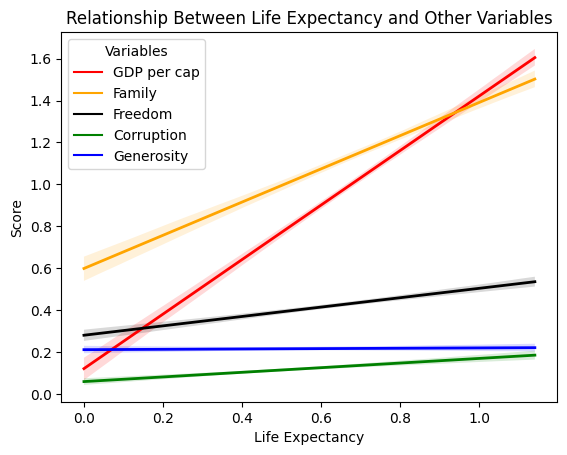

Model Evaluation:
Life Expectancy x GDP per cap:  r = 0.787,   p = 0.000,   R-squared = 0.619
Life Expectancy x Family:  r = 0.597,   p = 0.000,   R-squared = 0.356
Life Expectancy x Freedom:  r = 0.367,   p = 0.000,   R-squared = 0.135
Life Expectancy x Corruption:  r = 0.260,   p = 0.000,   R-squared = 0.067
Life Expectancy x Generosity:  r = 0.017,   p = 0.646,   R-squared = 0.000


In [33]:
x_var = 'Life Expectancy'
y_vars = ['GDP per cap', 'Family', 'Freedom', 'Corruption', 'Generosity']
colors = ['red', 'orange', 'black', 'green', 'blue']

for y, c in zip(y_vars, colors):

    sns.regplot(
        data=combined_df,
        x=x_var, y=y,
        scatter=False,
        line_kws={'color': c, 'linewidth': 2},
    )

    handles.append(plt.Line2D([], [], color=c))

plt.xlabel(x_var)
plt.ylabel("Score")
plt.title(f"Relationship Between {x_var} and Other Variables")

plt.legend(handles, y_vars, title="Variables")

plt.show()
print('Model Evaluation:')
for y in y_vars:
    df_clean = combined_df[[x_var, y]].dropna()
    X = df_clean[x_var].values
    Y = df_clean[y].values
    r, p = pearsonr(X, Y)
    coeffs = np.polyfit(X, Y, 1)
    pred = np.polyval(coeffs, X)
    r2 = r2_score(Y, pred)

    print(f'{x_var} x {y}:  r = {r:.3f},   p = {p:.3f},   R-squared = {r2:.3f}')


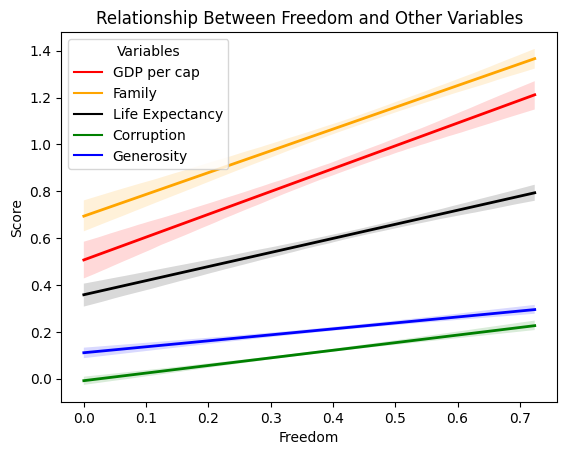

Model Evaluation:
Freedom x GDP per cap:  r = 0.360,   p = 0.000,   R-squared = 0.129
Freedom x Family:  r = 0.427,   p = 0.000,   R-squared = 0.182
Freedom x Life Expectancy:  r = 0.367,   p = 0.000,   R-squared = 0.135
Freedom x Corruption:  r = 0.465,   p = 0.000,   R-squared = 0.216
Freedom x Generosity:  r = 0.318,   p = 0.000,   R-squared = 0.101


In [34]:
x_var = 'Freedom'
y_vars = ['GDP per cap', 'Family', 'Life Expectancy', 'Corruption', 'Generosity']
colors = ['red', 'orange', 'black', 'green', 'blue']

for y, c in zip(y_vars, colors):

    sns.regplot(
        data=combined_df,
        x=x_var, y=y,
        scatter=False,
        line_kws={'color': c, 'linewidth': 2},
    )

    handles.append(plt.Line2D([], [], color=c))

plt.xlabel(x_var)
plt.ylabel("Score")
plt.title(f"Relationship Between {x_var} and Other Variables")

plt.legend(handles, y_vars, title="Variables")

plt.show()

print('Model Evaluation:')
for y in y_vars:
    df_clean = combined_df[[x_var, y]].dropna()
    X = df_clean[x_var].values
    Y = df_clean[y].values
    r, p = pearsonr(X, Y)
    coeffs = np.polyfit(X, Y, 1)
    pred = np.polyval(coeffs, X)
    r2 = r2_score(Y, pred)

    print(f'{x_var} x {y}:  r = {r:.3f},   p = {p:.3f},   R-squared = {r2:.3f}')


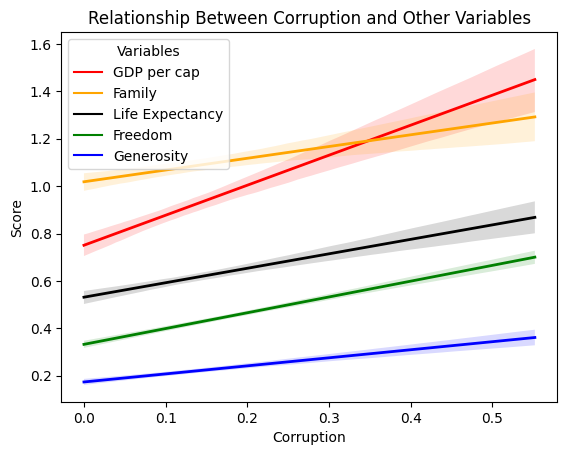

Model Evaluation:
Corruption x GDP per cap:  r = 0.328,   p = 0.000,   R-squared = 0.108
Corruption x Family:  r = 0.159,   p = 0.000,   R-squared = 0.025
Corruption x Life Expectancy:  r = 0.260,   p = 0.000,   R-squared = 0.067
Corruption x Freedom:  r = 0.465,   p = 0.000,   R-squared = 0.216
Corruption x Generosity:  r = 0.296,   p = 0.000,   R-squared = 0.088


In [35]:
x_var = 'Corruption'
y_vars = ['GDP per cap', 'Family', 'Life Expectancy', 'Freedom', 'Generosity']
colors = ['red', 'orange', 'black', 'green', 'blue']

for y, c in zip(y_vars, colors):

    sns.regplot(
        data=combined_df,
        x=x_var, y=y,
        scatter=False,
        line_kws={'color': c, 'linewidth': 2},
    )

    handles.append(plt.Line2D([], [], color=c))

plt.xlabel(x_var)
plt.ylabel("Score")
plt.title(f"Relationship Between {x_var} and Other Variables")

plt.legend(handles, y_vars, title="Variables")

plt.show()

print('Model Evaluation:')
for y in y_vars:
    df_clean = combined_df[[x_var, y]].dropna()
    X = df_clean[x_var].values
    Y = df_clean[y].values
    r, p = pearsonr(X, Y)
    coeffs = np.polyfit(X, Y, 1)
    pred = np.polyval(coeffs, X)
    r2 = r2_score(Y, pred)

    print(f'{x_var} x {y}:  r = {r:.3f},   p = {p:.3f},   R-squared = {r2:.3f}')


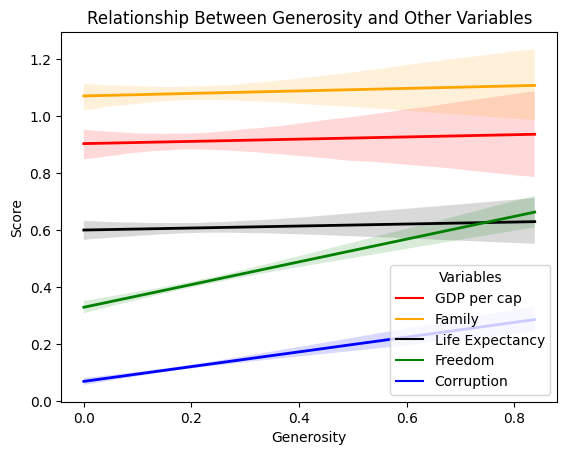

Model Evaluation:
Generosity x GDP per cap:  r = 0.012,   p = 0.757,   R-squared = 0.000
Generosity x Family:  r = 0.016,   p = 0.665,   R-squared = 0.000
Generosity x Life Expectancy:  r = 0.017,   p = 0.646,   R-squared = 0.000
Generosity x Freedom:  r = 0.318,   p = 0.000,   R-squared = 0.101
Generosity x Corruption:  r = 0.296,   p = 0.000,   R-squared = 0.088


In [36]:
x_var = 'Generosity'
y_vars = ['GDP per cap', 'Family', 'Life Expectancy', 'Freedom', 'Corruption']
colors = ['red', 'orange', 'black', 'green', 'blue']

for y, c in zip(y_vars, colors):

    sns.regplot(
        data=combined_df,
        x=x_var, y=y,
        scatter=False,
        line_kws={'color': c, 'linewidth': 2},
    )

    handles.append(plt.Line2D([], [], color=c))

plt.xlabel(x_var)
plt.ylabel("Score")
plt.title(f"Relationship Between {x_var} and Other Variables")

plt.legend(handles, y_vars, title="Variables")

plt.show()

print('Model Evaluation:')
for y in y_vars:
    df_clean = combined_df[[x_var, y]].dropna()
    X = df_clean[x_var].values
    Y = df_clean[y].values
    r, p = pearsonr(X, Y)
    coeffs = np.polyfit(X, Y, 1)
    pred = np.polyval(coeffs, X)
    r2 = r2_score(Y, pred)

    print(f'{x_var} x {y}:  r = {r:.3f},   p = {p:.3f},   R-squared = {r2:.3f}')

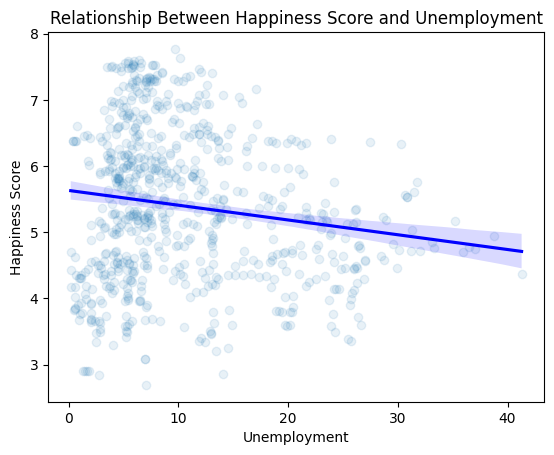

Model Evaluation:
Unemployment x Happiness Score:  r = -0.151,  p = 0.000,  R-squared = 0.023


In [37]:
# Visualise relationship between unemployment and happiness score

sns.regplot(data=combined_df, x='Unemployment', y='Happiness Score',
            scatter_kws={'alpha':0.1}, line_kws={'color':'blue'})

plt.xlabel('Unemployment')
plt.ylabel('Happiness Score')
plt.title('Relationship Between Happiness Score and Unemployment')
plt.show()

df_clean = combined_df[['Unemployment', 'Happiness Score']].dropna()

X = df_clean[['Unemployment']].values
Y = df_clean['Happiness Score'].values

# Linear regression model for r-squared
model = LinearRegression().fit(X, Y)
r2 = model.score(X, Y)

# Pearson correlation
r, p = pearsonr(df_clean['Unemployment'], df_clean['Happiness Score'])

print("Model Evaluation:")
print(f"Unemployment x Happiness Score:  r = {r:.3f},  p = {p:.3f},  R-squared = {r2:.3f}")


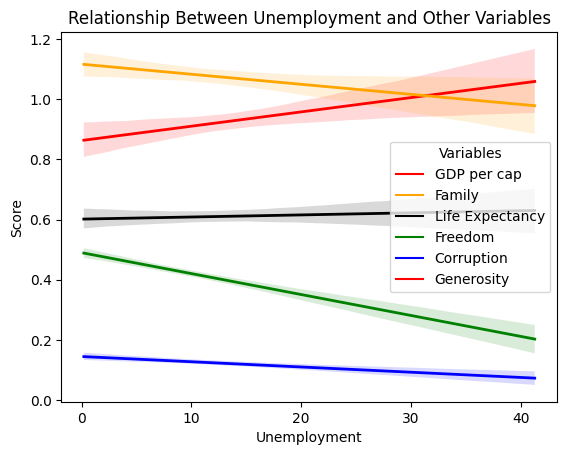

Model Evaluation:
Unemployment x GDP per cap:  r = 0.089,   p = 0.017,   R-squared = 0.008
Unemployment x Family:  r = -0.078,   p = 0.036,   R-squared = 0.006
Unemployment x Life Expectancy:  r = 0.022,   p = 0.563,   R-squared = 0.000
Unemployment x Freedom:  r = -0.353,   p = 0.000,   R-squared = 0.125
Unemployment x Corruption:  r = -0.127,   p = 0.001,   R-squared = 0.016
Unemployment x Generosity:  r = -0.345,   p = 0.000,   R-squared = 0.119


In [38]:
# Visualise the relationship between unemployment and happiness score contributors

x_var = 'Unemployment'
y_vars = ['GDP per cap', 'Family', 'Life Expectancy', 'Freedom', 'Corruption', 'Generosity']
colors = ['red', 'orange', 'black', 'green', 'blue']

for y, c in zip(y_vars, colors):

    sns.regplot(
        data=combined_df,
        x=x_var, y=y,
        scatter=False,
        line_kws={'color': c, 'linewidth': 2},
    )

    handles.append(plt.Line2D([], [], color=c))

plt.xlabel(x_var)
plt.ylabel("Score")
plt.title(f"Relationship Between {x_var} and Other Variables")

plt.legend(handles, y_vars, title="Variables")

plt.show()

print('Model Evaluation:')
for y in y_vars:
    df_clean = combined_df[[x_var, y]].dropna()
    X = df_clean[x_var].values
    Y = df_clean[y].values
    r, p = pearsonr(X, Y)
    coeffs = np.polyfit(X, Y, 1)
    pred = np.polyval(coeffs, X)
    r2 = r2_score(Y, pred)

    print(f'{x_var} x {y}:  r = {r:.3f},   p = {p:.3f},   R-squared = {r2:.3f}')

### 3. Linear regressions on significant inter-factor relationships and unemployment:

Our inclusion criteria for these regressions was correlations with r values greater than 0.5 and p values less than 0.05.

We also elected to include unemployment as despite previous testing showing weak to moderate correlations with other factors, we felt these insignificant relationships could warrant further testing to assess whether unemployment could replace factors which are highly correlated (and thus one is made somewhat redundant) to create a more accurate model to measure happiness.


In [ ]:
#linear regression for unemployment and happiness
#resource used: https://www.statsmodels.org/v0.14.4/generated/statsmodels.regression.linear_model.OLS.html
#didnt end up using sklearn (oops!)
import statsmodels.formula.api as smf
regressdata1 = combined_df[['Unemployment','Happiness Score']]

model = smf.ols("Q('Happiness Score') ~ Unemployment", data=regressdata1).fit()
#couldnt get it to work without quoting column name
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     Q('Happiness Score')   R-squared:                       0.023
Model:                              OLS   Adj. R-squared:                  0.022
Method:                   Least Squares   F-statistic:                     16.86
Date:                  Mon, 15 Dec 2025   Prob (F-statistic):           4.49e-05
Time:                          16:27:09   Log-Likelihood:                -1110.7
No. Observations:                   722   AIC:                             2225.
Df Residuals:                       720   BIC:                             2235.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.6312     

In [40]:
#linear regression for gdp/capita and family
regressdata2 = combined_df[['GDP per cap','Family']]

model = smf.ols("Q('GDP per cap') ~ Family", data=regressdata2).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Q('GDP per cap')   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     398.9
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           5.85e-71
Time:                        16:27:09   Log-Likelihood:                -225.30
No. Observations:                 722   AIC:                             454.6
Df Residuals:                     720   BIC:                             463.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1087      0.042      2.584      0.0

In [41]:
#linear regression gdp/capita life expectancy
regressdata3 = combined_df[['GDP per cap','Life Expectancy']]

model = smf.ols("Q('GDP per cap') ~ Q('Life Expectancy')", data=regressdata3).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Q('GDP per cap')   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     1170.
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          5.26e-153
Time:                        16:27:09   Log-Likelihood:                -36.130
No. Observations:                 722   AIC:                             76.26
Df Residuals:                     720   BIC:                             85.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1212 

In [42]:
#linear regression family and life expectancy
regressdata4 = combined_df[['Family','Life Expectancy']]

model = smf.ols("Q('Family') ~ Q('Life Expectancy')", data=regressdata4).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Q('Family')   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     398.3
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           7.15e-71
Time:                        16:27:09   Log-Likelihood:                -66.944
No. Observations:                 722   AIC:                             137.9
Df Residuals:                     720   BIC:                             147.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5988 

### 4. Multiple regressions with various significant factors including unemployment:
Initial multiple linear regression was performed to assess how substitutable unique UN world happiness collected data was with unemployment statistics. 

I.e. could we still get a reliable measure of happiness by only using data that is already regularly collected by states and various intergovernmental organizations. 

Taking note of the correlation between life expectancy and GDP per Capita, we then performed a second multiple linear regression, but removing life expectancy, noticing that the r^2 fell. Given this, we concluded that the first model (x= Life Expectancy, GDP per Capita, Unemployment) was better.


In [43]:
import statsmodels.api as sm
data = combined_df[['Happiness Score','Unemployment', 'GDP per cap', 'Life Expectancy']]

y = data['Happiness Score']
X = data[['GDP per cap', 'Life Expectancy','Unemployment']]
X = sm.add_constant(X) #for intercept

model = sm.OLS(y, X).fit() 

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Happiness Score   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     654.4
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          6.85e-205
Time:                        16:27:14   Log-Likelihood:                -643.40
No. Observations:                 722   AIC:                             1295.
Df Residuals:                     718   BIC:                             1313.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.3934      0.065     

In [44]:
conf_int = model.conf_int(alpha=0.05) 
conf_int.columns = ['Lower CI', 'Upper CI']
print(conf_int)

                 Lower CI  Upper CI
const            3.265279  3.521460
GDP per cap      1.399284  1.741432
Life Expectancy  1.187284  1.750552
Unemployment    -0.036429 -0.025162


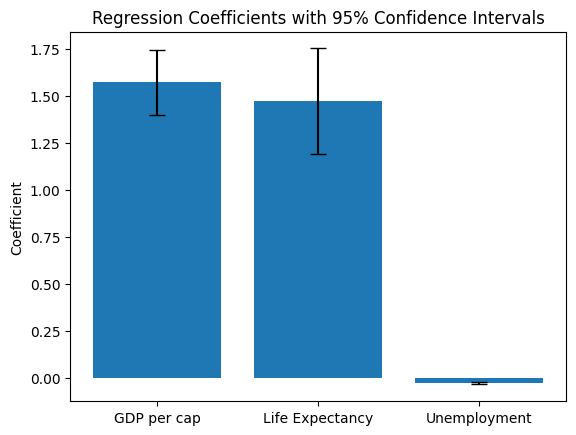

In [ ]:
params = model.params
conf_int = model.conf_int(alpha=0.05)
conf_int.columns = ['Lower CI', 'Upper CI']

#exclude intercept 
variables = conf_int.index.drop('const')

coefficients = params[variables]
lower_ci = conf_int.loc[variables, 'Lower CI']
upper_ci = conf_int.loc[variables, 'Upper CI']

#compute error bars
errors = [coefficients - lower_ci,upper_ci - coefficients]

fig, ax = plt.subplots()
x = np.arange(len(variables))

ax.bar(x,coefficients,yerr=errors,capsize=6)
ax.set_xticks(x)
ax.set_xticklabels(variables)
ax.set_ylabel('Coefficient')
ax.set_title('Regression Coefficients with 95% Confidence Intervals')

plt.show()

In [46]:
#trying again but removing life expectancy given that LE and GDP/Capita are somewhat well correlated
data = combined_df[['Happiness Score','Unemployment', 'GDP per cap']]

y = data['Happiness Score']
X = data[['GDP per cap', 'Unemployment']]
X = sm.add_constant(X) #for intercept

model = sm.OLS(y, X).fit() 

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Happiness Score   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     811.9
Date:                Mon, 15 Dec 2025   Prob (F-statistic):          3.70e-185
Time:                        16:27:14   Log-Likelihood:                -692.61
No. Observations:                 722   AIC:                             1391.
Df Residuals:                     719   BIC:                             1405.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.6702      0.064     57.777   

In [47]:
conf_int = model.conf_int(alpha=0.05) 
conf_int.columns = ['Lower CI', 'Upper CI']
print(conf_int)

              Lower CI  Upper CI
const         3.545480  3.794905
GDP per cap   2.160949  2.386235
Unemployment -0.039120 -0.027104


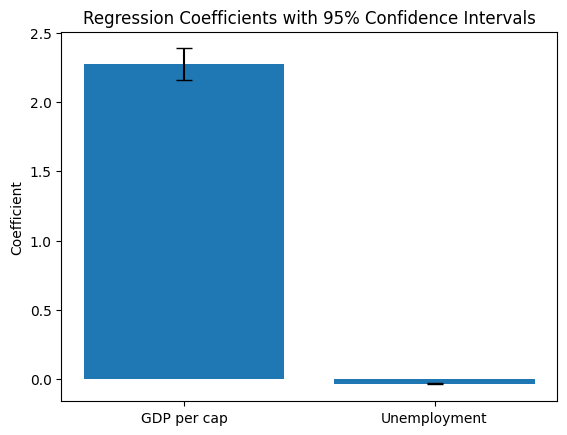

In [ ]:
#Higher GDP per capita is associated with higher happiness
#Higher unemployment is associated with lower happiness

params = model.params
conf_int = model.conf_int(alpha=0.05)
conf_int.columns = ['Lower CI', 'Upper CI']

#exclude intercept
variables = conf_int.index.drop('const')

coefficients = params[variables]
lower_ci = conf_int.loc[variables, 'Lower CI']
upper_ci = conf_int.loc[variables, 'Upper CI']

#compute error bars
errors = [coefficients - lower_ci,upper_ci - coefficients]

fig, ax = plt.subplots()
x = np.arange(len(variables))

ax.bar(x,coefficients,yerr=errors,capsize=6)
ax.set_xticks(x)
ax.set_xticklabels(variables)
ax.set_ylabel('Coefficient')
ax.set_title('Regression Coefficients with 95% Confidence Intervals')

plt.show()

### Findings and Conclusions:
Unemployment is a decent substitute (R^2 when used in Multiple Linear Regression with other objective data > 0.7). Removing Life Expectancy reduces the R^2 of the model by ~3, and therefore should be retained.

GDP per capita shows strong positive associations with life expectancy and family support

Generosity displays weak or negligible associations with most variables

Unemployment shows stronger associations with economic and institutional variables such as GDP per capita and corruption than with other variables.

Higher unemployment is associated with lower happiness, and higher GDP per capita is associated with higher happiness


Following our analysis, we have identified that the UN’s world happiness report could be constructed differently using more objective, standard, economic and demographic data already collected by states and institutions. This is evidenced by the high R^2 value of our multiple linear regression model, combining Unemployment, GDP per Capita, and Life expectancy. Some metrics, such as generosity may be somewhat negligible in the construction of the current report.


### Scope for Further Study:
Future investigations could expand our temporal scope by incorporating post-2020 data from sources like the World Bank's updated unemployment series or extended World Happiness Reports, capturing how pandemic-induced shocks and recovery policies reshaped unemployment-happiness dynamics.

It would also be interesting to analyse each country individually, allowing us to compare within-country changes over time rather than relying solely on cross-country averages.
Alongside this, this could raise the question of introducing more objective and easily obtained economic and demographic data into the world happiness report in the future. 

Most importantly, our findings suggest that the factors with less predictive power within the main multiple-linear-regression model should be re-evaluated qualitatively for their suitability compared to the more powerful variables, or at least if the happiness score reflects as close to ‘real’ happiness as it could be.
